### Libraries

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import itertools
import seaborn as sns

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

import joblib
import pickle

### DataSet

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
train_data.info()
print('_ '*30)
# test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 


In [4]:
## Sex, pclass, Embarked, Cabin as categorical
## Age, Fare are continuos Numeric
## Parch , SibSp as discrete numeric

## Cabin, Age, Embarked as NULL values, that we need to handle

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_data.describe()
## some passenger paid too  much money.. cox the 75th quantile is just 31, whereas max value is 512
## more than 75% of passenger are < 38yr old

## cabin might contain pattern - find that out

## check unique in pclass, SibSp, parch, Cabin, Embarked

## value counts for SibSp, parch, Embarked, cabin (if possible) , pclass := also value counts with Survived
#  histograms for fares ,  age


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Exploration

In [6]:
numeric_data = train_data[['Age', 'Fare', 'Parch', 'SibSp', 'Survived']]
cat_data = train_data[['Pclass', 'Embarked', 'Sex', 'Ticket', 'Cabin', 'Survived']]

#### numeric columns

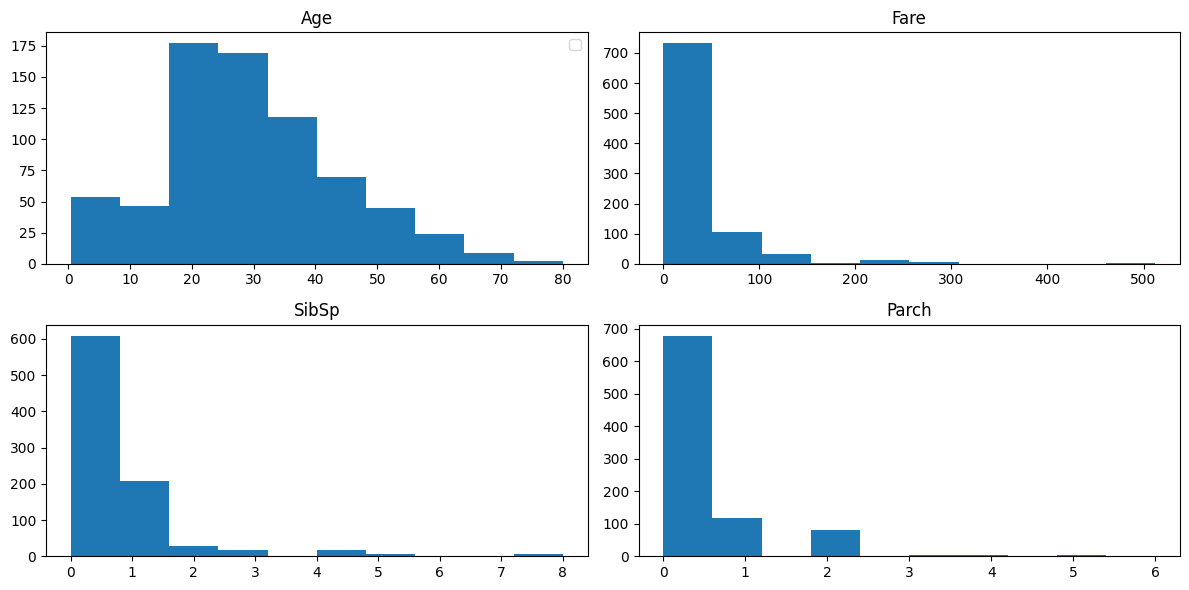

In [7]:
fig, axes = plt.subplots(2,2, figsize=(12,6))

axes[0,0].hist(numeric_data[['Age']])
axes[0,0].set_title('Age')
axes[0,0].legend()

axes[0,1].hist(numeric_data['Fare'])
axes[0,1].set_title('Fare')

axes[1,0].hist(numeric_data['SibSp'])
axes[1,0].set_title('SibSp')

axes[1,1].hist(numeric_data['Parch'])
axes[1,1].set_title('Parch')

plt.tight_layout()
plt.show()

# Age is Normally Distributed
# Fare, SibSp, Parch needs to be standardized

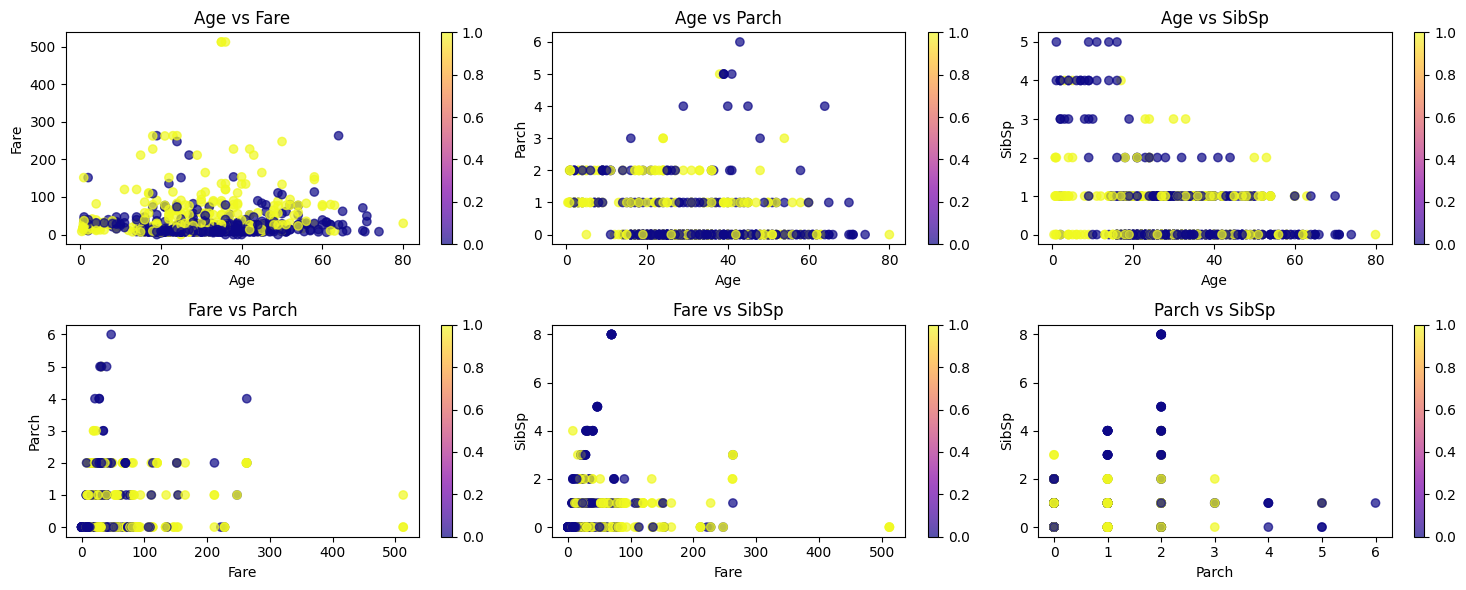

In [8]:
fig, axes = plt.subplots(2,3, figsize=(15,6))

scatter_cols = ['Age', 'Fare', 'Parch', 'SibSp']
combinations = list(itertools.combinations(scatter_cols, 2))

axes = axes.flatten()

for i, (x_col, y_col) in enumerate(combinations):
    ax = axes[i]
    sc = ax.scatter(numeric_data[x_col], numeric_data[y_col] , c=numeric_data['Survived'], cmap= 'plasma', alpha=0.7)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(f'{x_col} vs {y_col}')

    plt.colorbar(sc, ax =ax )

plt.tight_layout()
plt.show()

## Looks like people paying high fare survived
## people above 60 majorly didn't survive
## children with siblings ,2 survived

<Axes: >

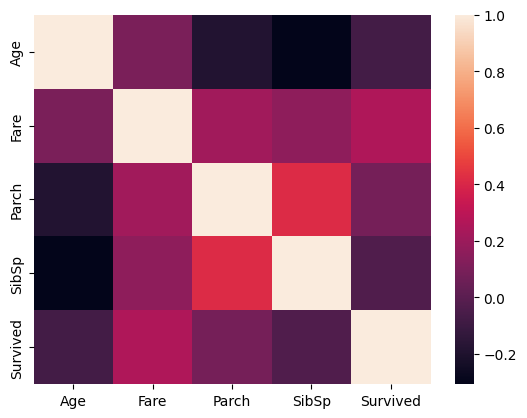

In [9]:
sns.heatmap(numeric_data.corr())

## there isn't much correlation

In [10]:
numeric_data_pivot = pd.pivot_table(numeric_data, values = ['Age', 'Fare', 'Parch', 'SibSp'], index = ['Survived'],
                                 aggfunc = {
                                    'Age': ['mean', 'median'],
                                    'Fare': ['mean', 'median'],
                                    'Parch':['mean', 'median'],
                                    'SibSp':['mean', 'median']
                                 })

numeric_data_pivot

Age              Fare            Parch            SibSp       
               mean median       mean median      mean median      mean median
Survived                                                                      
0         30.626179   28.0  22.117887   10.5  0.329690    0.0  0.553734    0.0
1         28.343690   28.0  48.395408   26.0  0.464912    0.0  0.473684    0.0

#### Categorical columns

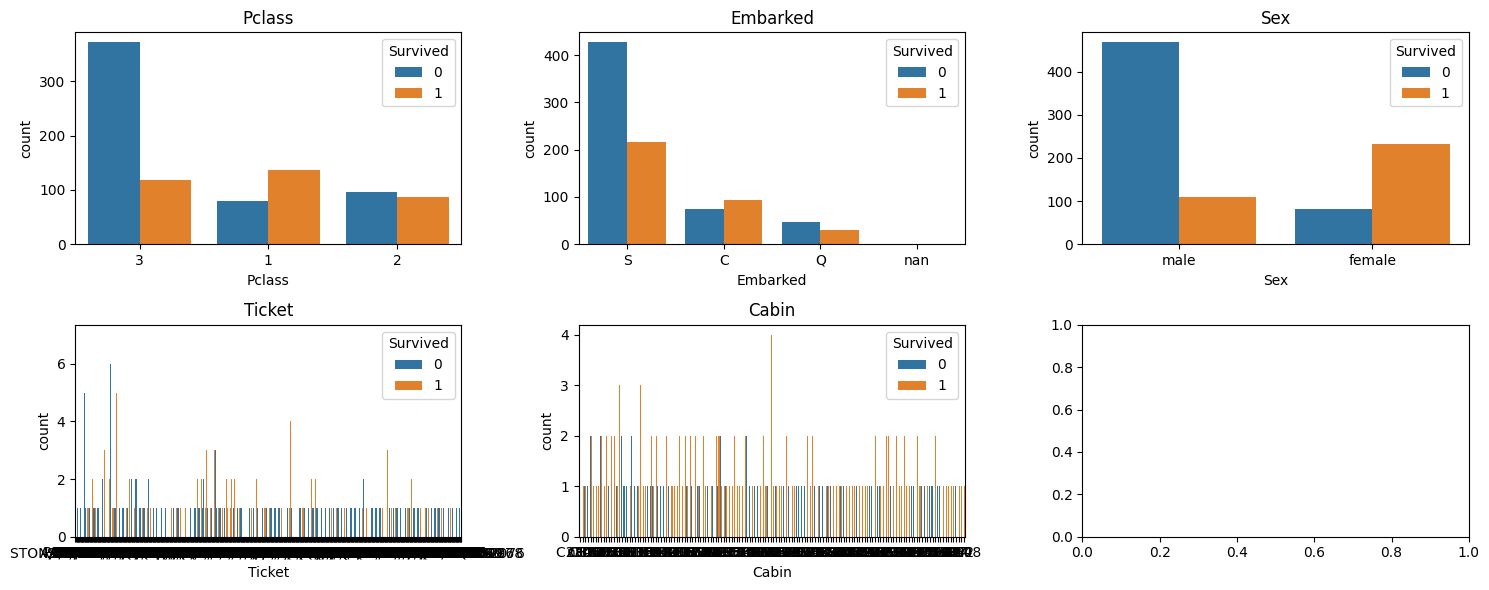

In [11]:
figure, axes = plt.subplots(2,3 , figsize=(15,6))
axes = axes.flatten()

for r in range(5):
    ax = axes[r]
    col = cat_data.columns[r]

    sns.countplot(data=cat_data, x= col, hue='Survived', order = cat_data[col].unique(), ax = ax )
    ax.set_title(col)

plt.tight_layout()
plt.show()

## so pclass, sex are relevant, maybe embarkation too

In [12]:
train_data['num_cabin'] = train_data['Cabin'].apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,num_cabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


<Axes: xlabel='num_cabin', ylabel='count'>

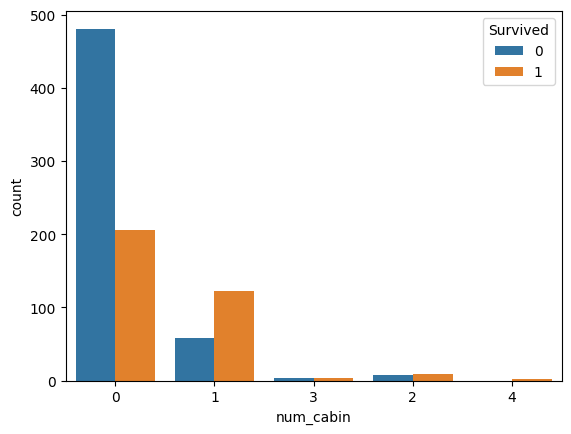

In [13]:
sns.countplot(data=train_data, x= 'num_cabin', hue='Survived', order = train_data['num_cabin'].unique())
# Seems the once having a cabin did survive

In [14]:
train_data['Cabin'].value_counts()

Cabin
G6             4
C23 C25 C27    4
B96 B98        4
F2             3
D              3
              ..
E17            1
A24            1
C50            1
B42            1
C148           1
Name: count, Length: 147, dtype: int64

In [ ]:
train_data['cabin_letter'] = train_data['Cabin'].apply(lambda x: 'n' if pd.isna(x)==True else str(x)[0])

<Axes: xlabel='cabin_letter', ylabel='count'>

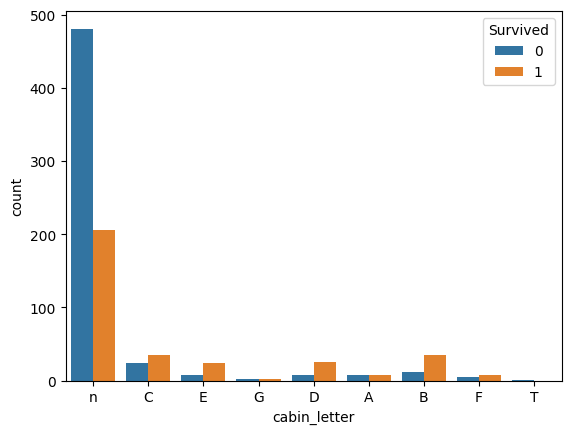

In [16]:
sns.countplot(data=train_data, x= 'cabin_letter', hue='Survived', order = train_data['cabin_letter'].unique())
## Cabin letter does matter it seems, at least higher proportion of people who had cabin survived

In [17]:
train_data['name_tag'] = train_data['Name'].apply(lambda x: x.split(' ')[1] )

In [18]:
train_data['name_tag'].nunique()

31

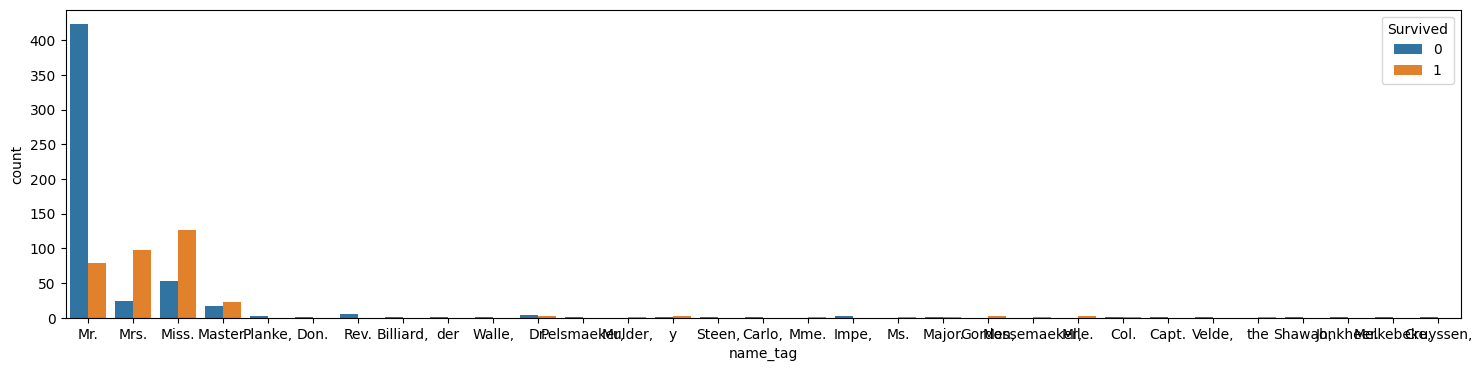

In [19]:
plt.figure(figsize=(18,4))
sns.countplot(data=train_data, x= 'name_tag', hue='Survived', order = train_data['name_tag'].unique())
plt.show()
## Seems mane tags like Miss, Mrs., master do have higher chance of survival

### Feature Engineering

1. Handle NULL values in Age, Embark, Cabin
2. Sex, pclass, Embarked, Cabin should be definitely CATEGORICAL
3. Age, Fare, Parch , SibSp are NUMERIC
4. Standardize all Numeric columns, also check Log scale thing
5. Numeric columns to choose as features are : 'Age', 'Fare', 'Parch', 'SibSp', num_cabin, 
6. Categorical Columns to use as feature are : Embarked, Sex, Pclass (convert to ordinal strings), cabin_letter, name_tag

I choose to work with following columns for training purpose:

'Pclass', 'Sex', 'Age', 'SibSp',
'Parch', 'Fare', 'Embarked', 'num_cabin',
'cabin_letter', 'name_tag'

target Column is 'Survived'

##### HANDLING NULL VALUES

In [20]:


train_data['Age'].fillna( train_data['Age'].mean() , inplace=True)
train_data['Fare'].fillna( train_data['Fare'].median() , inplace=True)

train_data.dropna(subset=['Embarked'], inplace=True)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   889 non-null    int64  
 1   Survived      889 non-null    int64  
 2   Pclass        889 non-null    int64  
 3   Name          889 non-null    object 
 4   Sex           889 non-null    object 
 5   Age           889 non-null    float64
 6   SibSp         889 non-null    int64  
 7   Parch         889 non-null    int64  
 8   Ticket        889 non-null    object 
 9   Fare          889 non-null    float64
 10  Cabin         202 non-null    object 
 11  Embarked      889 non-null    object 
 12  num_cabin     889 non-null    int64  
 13  cabin_letter  889 non-null    object 
 14  name_tag      889 non-null    object 
dtypes: float64(2), int64(6), object(7)
memory usage: 111.1+ KB


##### dtypes , Normalizations

In [21]:
train_data['Pclass'] = train_data['Pclass'].astype(str)

# converting parent, sibling counts and fare to log scale - for better normalization

train_data['norm_parents'] = np.log(train_data['Parch'] + 1)
train_data['norm_sib'] = np.log(train_data['SibSp'] + 1)
train_data['norm_fare'] = np.log(train_data['Fare'] + 1)


<Axes: >

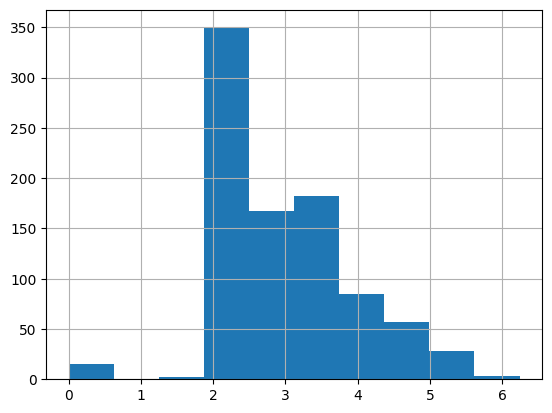

In [22]:
# train_data['norm_parents'].hist() # not usable
# plt.show()
# train_data['norm_sib'].hist() # not usable
# plt.show()
train_data['norm_fare'].hist()

In [23]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,num_cabin,cabin_letter,name_tag,norm_parents,norm_sib,norm_fare
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,n,Mr.,0.0,0.693147,2.110213
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,C,Mrs.,0.0,0.693147,4.280593
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,n,Miss.,0.0,0.000000,2.188856
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,C,Mrs.,0.0,0.693147,3.990834
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,n,Mr.,0.0,0.000000,2.202765


##### Drop Columns, OneHotEncoding 

LightGBM deosn't require one hot encoding

In [24]:
training_set = train_data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Fare', 'Cabin', 'norm_parents', 'norm_sib'])
training_set.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,num_cabin,cabin_letter,name_tag,norm_fare
0,0,3,male,22.0,1,0,S,0,n,Mr.,2.110213
1,1,1,female,38.0,1,0,C,1,C,Mrs.,4.280593
2,1,3,female,26.0,0,0,S,0,n,Miss.,2.188856
3,1,1,female,35.0,1,0,S,1,C,Mrs.,3.990834
4,0,3,male,35.0,0,0,S,0,n,Mr.,2.202765


In [25]:
scaler = MinMaxScaler()
training_set[['Age', 'norm_fare']] = scaler.fit_transform( training_set[['Age', 'norm_fare']] )

##### Same Data Trasformations on test data

In [26]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [27]:
test_data['Age'].fillna( test_data['Age'].mean() , inplace=True)
test_data['Fare'].fillna( test_data['Fare'].median() , inplace=True)

test_data['Pclass'] = test_data['Pclass'].astype(str)
test_data['norm_fare'] = np.log( test_data['Fare'] + 1)

test_data['num_cabin'] = test_data['Cabin'].apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
test_data['cabin_letter'] = test_data['Cabin'].apply(lambda x: 'n' if pd.isna(x)==True else str(x)[0])
test_data['name_tag'] = test_data['Name'].apply(lambda x: x.split(' ')[1] )

test_set = test_data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked', 'num_cabin', 'cabin_letter', 'name_tag', 'norm_fare']]

In [28]:
test_set.head()

,Pclass,Sex,Age,SibSp,Parch,Embarked,num_cabin,cabin_letter,name_tag,norm_fare
0,3,male,34.5,0,0,Q,0,n,Mr.,2.178064
1,3,female,47.0,1,0,S,0,n,Mrs.,2.079442
2,2,male,62.0,0,0,Q,0,n,Mr.,2.369075
3,3,male,27.0,0,0,S,0,n,Mr.,2.268252
4,3,female,22.0,1,1,S,0,n,Mrs.,2.586824


In [29]:
test_set[['Age', 'norm_fare']] = scaler.transform(test_set[['Age', 'norm_fare']])

In [30]:
pickle.dump(scaler, open('scaling.pkl', 'wb'))

### Model building

#### loading dataset for LightBGM

In [31]:
# Find all object columns
cat_cols = ['Pclass', 'Sex', 'Embarked', 'cabin_letter', 'name_tag']

# Convert to category dtype
for col in cat_cols:
    training_set[col] = training_set[col].astype('category')

In [32]:
## test train split

X = training_set[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked', 'num_cabin', 'cabin_letter', 'name_tag', 'norm_fare']]
y = training_set['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
## lightGBM datasets

train_lgb_data = lgb.Dataset(X_train, label=y_train, categorical_feature= ['Pclass', 'Sex', 'Embarked', 'cabin_letter', 'name_tag' ])
test_lgb_data = lgb.Dataset(X_test, label=y_test, reference=train_lgb_data)

#### train the model

In [ ]:
# Define hyperparameters
params = {
    "objective": "binary",
    "boosting_type": "rf",
    "num_leaves": 10,
    "force_row_wise": True,
    "learning_rate": 0.2,
    "metric": "binary_logloss",
    "bagging_fraction": 0.8,
    "feature_fraction": 0.8
}

# Train the LightGBM model
num_round = 2000
bst = lgb.train(params, train_lgb_data,
                 num_round,
                  valid_sets=[test_lgb_data])

[LightGBM] [Info] Number of positive: 271, number of negative: 440
[LightGBM] [Info] Total Bins 225
[LightGBM] [Info] Number of data points in the train set: 711, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.381153 -> initscore=-0.484656
[LightGBM] [Info] Start training from score -0.484656


### Model Evaluation

In [36]:
# Make predictions
y_pred = bst.predict(X_test)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1score = f1_score(y_test, y_pred_binary)
# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1score:.4f}")

Accuracy: 0.7978
Precision: 0.7538
Recall: 0.7101
F1-Score: 0.7313


In [37]:
# Generate classification report
report = classification_report(y_test, y_pred_binary)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.85      0.84       109
           1       0.75      0.71      0.73        69

    accuracy                           0.80       178
   macro avg       0.79      0.78      0.78       178
weighted avg       0.80      0.80      0.80       178



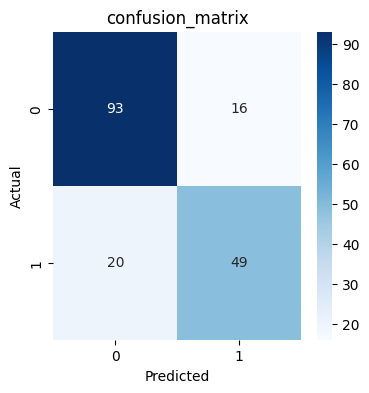

In [40]:
cm = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('confusion_matrix')
plt.show()

In [41]:
pickle.dump(bst, open('LGB_model.pkl', 'wb'))

In [59]:
train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,num_cabin,cabin_letter,name_tag,norm_parents,norm_sib,norm_fare
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S,0,n,Mr.,0.000000,0.693147,2.110213
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,1,C,Mrs.,0.000000,0.693147,4.280593
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,0,n,Miss.,0.000000,0.000000,2.188856
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,1,C,Mrs.,0.000000,0.693147,3.990834
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S,0,n,Mr.,0.000000,0.000000,2.202765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,NaN,S,0,n,Rev.,0.000000,0.000000,2.639057
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,B42,S,1,B,Miss.,0.000000,0.000000,3.433987
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,NaN,S,0,n,Miss.,1.098612,0.693147,3.196630
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C148,C,1,C,Mr.,0.000000,0.000000,3.433987


In [60]:
import json
(json.dumps(train_data.iloc[3].to_dict()))

'{"PassengerId": 4, "Survived": 1, "Pclass": "1", "Name": "Futrelle, Mrs. Jacques Heath (Lily May Peel)", "Sex": "female", "Age": 35.0, "SibSp": 1, "Parch": 0, "Ticket": "113803", "Fare": 53.1, "Cabin": "C123", "Embarked": "S", "num_cabin": 1, "cabin_letter": "C", "name_tag": "Mrs.", "norm_parents": 0.0, "norm_sib": 0.6931471805599453, "norm_fare": 3.9908341858524357}'

In [45]:
y_test

281    0
435    1
39     1
418    0
585    1
      ..
433    0
807    0
25     1
85     1
10     1
Name: Survived, Length: 178, dtype: int64